# Binary random alloy with dilute vacancy
Multiple approaches to the same model binary alloy, evaluated numerically.

### Model
Our model is quite simple: there are A and B atoms, and one vacancy, in a periodic lattice. There is a concentration $c_\text{B}$ of B atoms (solute). Only the vacancy is mobile. The thermodynamics are kept very simple: A, B, and vacancies have no interaction. There are only two rates in the problem: $\nu_\text{A}$ and $\nu_\text{B}$ which are the rates of vacancy-A and vacancy-B atom exchanges. Without loss of generality, we take $\nu_\text{A}=1$, and the lattice constant to be 1. We will solve our problem on a square lattice.

### Cases
We will study variation with concentration $c_\text{B}$ (and $c_\text{A}=1-c_\text{B}$ for a dilute limit of vacancies), for three different choices of $\nu_\text{B}/\nu_\text{A}$:

1. $\nu_\text{B}=\nu_\text{A}$. This is the "tracer" case, and the most trivial.
2. $\nu_\text{B}=4\nu_\text{A}$. This is the case of a "fast" diffuser. We could take much faster, but this begins to become limiting for KMC.
3. $\nu_\text{B}=0$. This is the case of a frozen solute, which has a percolation limit at finite concentration of $c_\text{B}<1$ where all diffusivities become 0.

### Approaches
We consider multiple models to evaluate their accuracy:

1. *Kinetic Monte Carlo.* We evaluate on a finite "supercell" lattice; this involves generating new starting configurations, running for finite "long" times, and averaging over multiple initial configurations.
2. *Mean-field Green function.* These expressions are known analytically. We also include a residual-bias correction evaluated for the frozen solute case.
3. *Bias-basis approximation.* Also known analytically; this ends up having the same functional form as the MFGF, with a different crystal structure parameter.
4. *Generalized self-consistent mean-field.* We study different ranges of "effective Hamiltonian," but solve using the most general case. This is equivalent to using all orders of cluster expansion out to a finite range of sites.

The 4 methods have different amounts of computational complexity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from scipy import sparse
from scipy.sparse.linalg import minres
import pyamg  # adaptive multigrid solver
import itertools
from tqdm import tnrange, tqdm_notebook  # progress bar; not necessary, but helpful for long runs

In [2]:
# Turn off or on to run optional testing code in notebook:
# Also turns on / off progress bars
__TESTING__ = False

Setting up our simple square lattice:

In [3]:
dxlist = [np.array([1,0]), np.array([-1,0]), np.array([0,1]), np.array([0,-1])]
z = len(dxlist) # coordination number
d = len(dxlist[0]) # dimension
Nt = 3 # number of species (A + B + vacancy)
print(dxlist)

[array([1, 0]), array([-1,  0]), array([0, 1]), array([ 0, -1])]


### Kinetic Monte Carlo functions
Below are some simple functions to run KMC simulations of diffusivity.

In [4]:
def make_connectivity(Npbc):
    """
    Makes an `Npbc` x `Npbc` square lattice, with Npbc. Returns a matrix of "connectivity"
    with dimensions (Nstates, coordination)
    
    :param Nbpc: size of square lattice
    :return connectivity: array of (Nstates, coordination) where for each state, 
        it gives the endpoint state for jump, indexed from our dxlist.
    """
    def toindex(nvec, Npbc):
        return (nvec[0]%Npbc) + Npbc*(nvec[1]%Npbc)
    def fromindex(n, Npbc):
        return (n%Npbc, n//Npbc)
    Nsites = Npbc**d
    connectivity = np.zeros((Nsites, z), dtype=int)
    for n in range(Nsites):
        st, c = fromindex(n, Npbc), connectivity[n]
        for i, dx in enumerate(dxlist):
            c[i] = toindex((st[0]+dx[0], st[1]+dx[1]), Npbc)
    return connectivity

In [5]:
if __TESTING__:
    conn = make_connectivity(16)
    for n, c in enumerate(conn):
        for m in c:
            if n not in conn[m]:
                print('Missing back connection from {} to {}?'.format(n, m))

We define our system state very simply:

* index corresponding to the vacancy site position `vacsite`
* `chemocc`, an integer vector of length `Nsites`, where values of 0 = A, 1 = B. Note: the value of `chemocc[vacsite]` is undefined, but ignored.

Because everything is random, we place the vacancy at site 0.

In [6]:
def generate_state(cB, Ns):
    """
    Generate an initial configuration for a given concentration, number of sites.

    :param cB: concentration of B atoms (probability a site has a B atom)
    :param Ns: number of sites
    
    :return vacsite: index of site corresponding to vacancy position
    :return chemocc: vector of chemistries at each site
    """
    vacsite, chemocc = 0, np.random.choice((0,1), Ns, p=(1.-cB, cB))
    chemocc[vacsite] = -1
    return vacsite, chemocc

In [7]:
def KMC_diff(cB, nuB, connectivity, Nkmc=1, Nsamples=2**8, Nerror=2**4):
    """
    Runs KMC to determine Onsager transport coefficients. A few parameters determine how the run goes:
    
    :param cB: concentration of "solute"
    :param nuB: relative rate of solute-vacancy exchange
    :param Nkmc: number of jumps to include in a trajectory; this is a multiplier on the number of sites
    :param Nsamples: number of trajectories to sample to determine the diffusivity
    :param Nerror: number of averages to use to estimate stochastic error
    
    :returns Lab: transport coefficients, for the different chemistries
    :returns dLab: standard deviation in Lab
    """
    Nsites = connectivity.shape[0]
    Lmat, dLmat = np.zeros((Nt, Nt)), np.zeros((Nt, Nt))
    for nerror in tnrange(Nerror, desc='L average', 
                          leave=False, disable=not __TESTING__):
        Dmat = np.zeros((Nt,Nt))
        for nsamp in range(Nsamples):
            displace = [np.zeros(2), np.zeros(2), np.zeros(2)]  # A, B, vacancy
            T = 0
            vacsite, chemocc = generate_state(cB, Nsites)
            # check to make sure there's an initial escape (important for nuB==0 only)
            if not((nuB == 0) and all(chemocc[j]==1 for j in connectivity[vacsite])):
                for nkmc in range(Nkmc*Nsites):
                    # rate table: very simple
                    rates = np.array([1. if chemocc[j]==0 else nuB 
                                      for j in connectivity[vacsite]])
                    # escape time
                    dT = 1./np.sum(rates)
                    # select the jump
                    jumptype = np.random.choice(z, p=dT*rates)
                    # accumulate
                    T += dT
                    displace[-1] += dxlist[jumptype]
                    newvac = connectivity[vacsite, jumptype]
                    displace[chemocc[newvac]] -= dxlist[jumptype]
                    # update state
                    chemocc[vacsite] = chemocc[newvac]
                    chemocc[newvac] = -1
                    vacsite = newvac
                for c1 in range(Nt):
                    for c2 in range(Nt):
                        Dmat[c1, c2] += np.dot(displace[c1], displace[c2])/(4*T)
        Dmat /= Nsamples
        Lmat += Dmat
        dLmat += Dmat**2
    Lmat /= Nerror
    dLmat /= Nerror
    return Lmat, np.sqrt((dLmat - Lmat**2)/Nerror)

In [8]:
# Faster implementation using precalculated rate tables, and generating
# all of the jump choices in advance, for the different environments

def KMC_diff_fast(cB, nuB, connectivity, Nkmc=1, Nsamples=2**8, Nerror=2**4):
    """
    Runs KMC to determine Onsager transport coefficients. A few parameters determine how the run goes:
    
    :param cB: concentration of "solute"
    :param nuB: relative rate of solute-vacancy exchange
    :param Nkmc: number of jumps to include in a trajectory; this is a multiplier on the number of sites
    :param Nsamples: number of trajectories to sample to determine the diffusivity
    :param Nerror: number of averages to use to estimate stochastic error
    
    :returns Lab: transport coefficients, for the different chemistries
    :returns dLab: standard deviation in Lab
    """
    Nsites = connectivity.shape[0]
    Lmat, dLmat = np.zeros((Nt, Nt)), np.zeros((Nt, Nt))

    # setup some rate tables.
    Nstates = 2**z
    bitlist = [1 << i for i in range(z)]  # mapping of index to bits
    intdict = {}
    for localchem in itertools.product((0,1), repeat=z):
        intdict[localchem] = sum(bitlist[i] for i, c in enumerate(localchem) if c)
    def int2index(i):
        """Takes in an integer and returns the mapping"""
        return [ 1 if i&bitlist[n] else 0 for n in range(z)]

    ratedict = np.zeros(Nstates)
    probdict = np.zeros((Nstates, z))
    for localchem in itertools.product((0,1), repeat=z):
        n = intdict[localchem]
        rates = np.array([1. if localchem[j]==0 else nuB for j in range(z)])
        if np.sum(rates) != 0:
            # escape time
            dT = 1./np.sum(rates)
            ratedict[n] = dT
            probdict[n,:] = dT*rates
        else:
            ratedict[n] = 0
            probdict[n,:] = np.array([1. for j in range(z)])

    # setup some random guesses
    Njumps = Nerror*Nsamples*Nsites*Nkmc  # total number of jumps needed
    ncount = np.zeros(Nstates, dtype=int)
    randjumps = []
    for n in range(Nstates):
        # estimate how many times we'll encounter a given environment:
        N = np.product([cB if c else (1.-cB) for c in int2index(n)])*Njumps
        N = 1+int(N + 3*np.sqrt(N)) # counting statistics; +3 standard deviations.
        ncount[n] = N-1
        if ratedict[n] > 0:
            randjumps.append(np.random.choice(z, N, p=probdict[n]))
        else:
            randjumps.append(np.array([0]))
    
    for nerror in tnrange(Nerror, desc='L average', 
                          leave=False, disable=not __TESTING__):
        Dmat = np.zeros((Nt,Nt))
        for nsamp in range(Nsamples):
            displace = [np.zeros(2, dtype=int), 
                        np.zeros(2, dtype=int), 
                        np.zeros(2, dtype=int)]  # A, B, vacancy
            T = 0
            vacsite, chemocc = generate_state(cB, Nsites)
            # check to make sure there's an initial escape (important for nuB==0 only)
            if ratedict[intdict[tuple(chemocc[j] for j in connectivity[vacsite])]] != 0:
                for nkmc in range(Nsites*Nkmc):
                    # rate table: very simple
                    n = intdict[tuple(chemocc[j] for j in connectivity[vacsite])]
                    # select the jump
                    jumptype = randjumps[n][ncount[n]]
                    ncount[n] -= 1
                    # accumulate escape time
                    T += ratedict[n]
                    displace[-1] += dxlist[jumptype]
                    newvac = connectivity[vacsite, jumptype]
                    displace[chemocc[newvac]] -= dxlist[jumptype]
                    # update state
                    chemocc[vacsite] = chemocc[newvac]
                    chemocc[newvac] = -1
                    vacsite = newvac
                    # check that we don't need more jumps:
                    if ncount[n] < 0:
                        randjumps[n] = np.random.choice(z, randjumps[n].shape[0], 
                                                        p=probdict[n])
                        ncount[n] = randjumps[n].shape[0]-1
                for c1 in range(Nt):
                    for c2 in range(Nt):
                        Dmat[c1, c2] += np.dot(displace[c1], displace[c2])/(4*T)
        Dmat /= Nsamples
        Lmat += Dmat
        dLmat += Dmat**2
    Lmat /= Nerror
    dLmat /= Nerror
    return Lmat, np.sqrt((dLmat - Lmat**2)/Nerror)

In [9]:
if __TESTING__:
    L, dL = KMC_diff(0.5, 2., make_connectivity(8))
    print(L)
    print(dL)

In [10]:
def percolation_diff(cB, connectivity, Nsamples=2**4, Nerror=2**4):
    """
    Directly computes diffusivity for a percolation problem (nuB==0)
    
    :param cB: concentration of "solute"
    :param Nsamples: number of configurations to sample to determine the diffusivity
    :param Nerror: number of averages to use to estimate stochastic error
    
    :returns Lab: transport coefficients, for the different chemistries
    :returns dLab: standard deviation in Lab
    """
    Nsites = connectivity.shape[0]
    Lmat, dLmat = 0., 0.
    for nerror in tnrange(Nerror, desc='L average', leave=False, disable=not __TESTING__):
        Dmat = 0
        for nsamp in range(Nsamples):
            D0 = 0
            vacsite, chemocc = generate_state(cB, Nsites)
            # break into connected domains (a list of connected networks)
            # first get a set of sites that are not B atoms
            asites = set(n for n,c in enumerate(chemocc) if c!=1)
            while asites:
                # try to create a new network:
                n = asites.pop()  # first member, random
                # two sets: the network being constructed, sites to branch from
                net, remainders = {n}, {n}
                while remainders:
                    # grab a new member whose connections we'll check:
                    n = remainders.pop()
                    for m in connectivity[n]:
                        if m in asites:
                            # m is in asites if we've not already checked its connections
                            net.add(m)
                            remainders.add(m)
                            asites.remove(m) # remove it from the global list
                if len(net)<2: continue
                D0 = 0
                sitelist = [n for n in net]
                siteindex = {n:i for i,n in enumerate(sitelist)}
                Ilist, Jlist, Vlist, blist = [], [], [], []
                for i,n in enumerate(sitelist):
                    conn = connectivity[n]
                    b0, d0 = 0., 0.
                    for m, dx in zip(conn, dxlist):
                        try: 
                            j = siteindex[m]
                            d0 += 1.
                            Ilist.append(i)
                            Jlist.append(j)
                            Vlist.append(1.)
                            b0 += dx[0]
                        except KeyError:
                            pass
                    blist.append(b0)
                    Ilist.append(i)
                    Jlist.append(i)
                    Vlist.append(-d0)
                    D0 += d0
                bvec = np.array(blist)
                W = sparse.csr_matrix((Vlist, (Ilist, Jlist)), 
                                      shape=(len(sitelist),len(sitelist)))
                etabar,info = minres(W, bvec, x0=np.random.rand(W.shape[0]), tol=1e-8)
                if info!=0: print('got {} return from minres'.format(info))
                etabar -= np.average(etabar)
                Dmat += (0.25*D0 + np.dot(bvec, etabar))/Nsites
                # Dmat += 0.25*D0/Nsites
        Dmat /= Nsamples
        Lmat += Dmat
        dLmat += Dmat**2
    Lmat /= Nerror
    dLmat /= Nerror
    return Lmat, np.sqrt((dLmat - Lmat**2)/Nerror)

### Mean-field Green function solution
These are simple analytic expressions; the built in crystal structure "parameter" is gamma, which is a function of the dilute tracer correlation coefficient ($f$) for a square lattice,
$$\gamma = \frac{f+1}{f-1}$$
We can get the bias basis solution by replacing this value with z, the coordination number.
$$\gamma_\text{bias basis} = -z$$
which corresponds to a dilute tracer correlation coefficient of $f=1-2/(z+1)$. The analytic solution for the square lattice is $f=1/(\pi-1)\approx 0.467$, so $\gamma = -\pi/(\pi-2) \approx -2.752$.

In [11]:
def Danalytic(cB, nuB, gamma = -(np.pi)/(np.pi-2)):
    """
    Analytic GF solution.

    :param cB: concentration of "solute"
    :param nuB: relative rate of solute-vacancy exchange
    :param gamma: optional parameter. This is (f+1)/(f-1) for full correlation, or -z for bias basis.

    :returns Lab: transport coefficients, for the different chemistries
    """
    cA, nuA = 1.-cB, 1.
    nuave = cA*nuA + cB*nuB
    bv = cA*(nuave-nuA) - cB*(nuave-nuB)
    g = 1./(gamma*nuave - (2*nuA + 2*nuB - 3*nuave))
    DAA = cA*nuA + 2*cA*cB*nuA*nuA*g
    DBB = cB*nuB + 2*cA*cB*nuB*nuB*g
    DAB = -2*cA*cB*nuA*nuB*g
    DvA = -cA*nuA + nuA*bv*g
    DvB = -cB*nuB - nuB*bv*g
    Dvv = nuave + cA*cB*((nuA-nuB)**2)*g
    return np.array([[DAA, DAB, DvA], [DAB, DBB, DvB], [DvA, DvB, Dvv]])

The **residual bias correction** allows for any linear basis solution, such as the mean-field Green function solution, to be corrected by using the residual bias as a new basis. For the percolation problem, we can construct an analytic expression that involves numerical terms to be evaluated.

In [37]:
def Dbiascorrect(cB):
    """
    Residual-bias corrected SCGF solution; only for nuB = 0, just returns DAA,
    which is already divided by cA.
    
    :param cB: concentration of "solute"
    
    :returns DAA: transport coefficient (diffusivity) of A.
    """
    # check edge cases first:
    if np.isclose(cB,1):
        return 0.
    return (1.-cB)/(1.+0.1415926534*cB) + \
        (-0.01272990905*cB + 4.529059154*cB**2 - 399.7080744*cB**3 - \
         561.6483202*cB**4 + 665.0100411*cB**5 + 622.9427624*cB**6 - \
         379.2388949*cB**7 + 48.12615674*cB**8)/\
        (1. + 361.2297602*cB + 590.7833342*cB**2 + 222.4121227*cB**3 + \
         307.7589952*cB**4 + 208.3266238*cB**5 - 52.05560275*cB**6 - \
         24.0423294*cB**7 - 1.884593043*cB**8)

In [13]:
if __TESTING__:
    LGF = Danalytic(0.5, 2.)
    Lbb = Danalytic(0.5, 2., gamma = -z)
    print(LGF)
    print(Lbb)

### Generalized self-consistent mean-field method
In this approach, we expand a basis set entirely from the local chemistry around the vacancy. By doing this explicitly in terms of the states, we capture all possible cluster expansions out to a fixed range. The computational complexity grows quite rapidly, so we keep the cutoff a bit short, as it grows like $2^n$ for $n$ sites around the vacancy.

First, we make lists of the sites we want to consider:

In [14]:
sitelists = [dxlist.copy()]
for shell in [[np.array([1,1]), np.array([1,-1]), np.array([-1,1]), np.array([-1,-1])], 
              [np.array([2,0]), np.array([-2,0]), np.array([0,2]), np.array([0,-2])],
              [np.array([2,1]), np.array([2,-1]), np.array([-2,1]), np.array([-2,-1])],
              [np.array([1,2]), np.array([-1,2]), np.array([1,-2]), np.array([-1,-2])],
              [np.array([2,2]), np.array([2,-2]), np.array([-2,2]), np.array([-2,-2])]]:
    sitelists.append(sitelists[-1].copy() + shell)
if __TESTING__:
    for s in sitelists:
        print(len(s), s)

Next, we make a function which constructs all of the necessary information for the states to make the Wbar and bbar matrices corresponding to our sitelists. It is recommended, that for a given sitelist, this only be done once, as it can be reused to make Wbar and bbar for different concentrations and rates.

Next: we are going to run through and construct our mappings. Here is what we will store:

* For each basis function (indexed by `n`), we will store a list of other basis functions to which it can transition; the rate type (0 or 1), and the probability factor as a tuple (nA, nB). This will be used to construct the off-diagonal components of `Wbar`.
* For each basis function, we will store the diagonal information as a probability factor and a single integer, which counts the number of nuB type of jumps (which is consistent with the off-diagonal components).
* For each basis function, the bias factors involve the same probability factor as the diagonal information. We don't bother computing both x and y, but rather get the A and B components (bV = -bA-bB). The rate information for xA is either +1 (==+nuA), 0 (==0) or -1 (==-nuA), and similar for B. WLOG, we look at the x component. So we can include this with the diagonal information.

In [15]:
def make_Wbarlists(sitelist):
    """
    Takes in a list of sites, and constructs two lists that contain all the information 
    needed to make Wbar and bbar.
    :param sitelist: list of sites to include
    :returns Wbarlist: list of information to construct off-diagonal components of Wbar
    :returns Wbardiag: list of information to construct diagonal components of Wbar *and* bbar vector
    """
    # helper functions and analysis:
    Nsites = len(sitelist)
    Nstates = 2**Nsites
    bitlist = [1 << i for i in range(Nsites)]  # mapping of index to bits, equivalent to 2**i
    def index2int(lis):
        """Takes a list returns the integer mapping"""
        return sum(bitlist[i] for i, c in enumerate(lis) if c)
    def int2index(i):
        """Takes in an integer and returns the mapping"""
        return [ 1 if i&bitlist[n] else 0 for n in range(Nsites)]
    # lists for shifts:
    # * `shiftlist` contains the new bit in the translated basis if that position is set in the current list
    # * `unsetbitlist` contains the list of bits that are "missing", and hence free to be set.
    shiftlist = []
    unsetbitlist = []
    for dx in dxlist:
        shifts = []
        for site in sitelist:
            if np.array_equal(site, dx):
                newsite = -dx
            else:
                newsite = site - dx
            # is that a site that we are tracking?
            try:
                newbit = bitlist[ [np.array_equal(newsite, s) for s in sitelist].index(True) ]
            except ValueError:
                newbit = 0
            shifts.append(newbit)
        shiftlist.append(shifts)
        unsetbitlist.append([b for b in bitlist if b not in shifts])

    Wbarlist = []
    Wbardiag = []
    Nnew = len(unsetbitlist[0])  # how many unset bits are there?
    for n in tnrange(Nstates, disable=not __TESTING__):
        lis = int2index(n)
        nB = sum(1 for c in lis if c)
        nA = Nsites-nB
        p = (nA, nB)
        # counters for our jumptype:
        nuBt, nuAx, nuBx = 0, 0, 0
        # now, run through our jumps (dx)
        Wbarentries = []
        for njump, dx, shifts, unsetbits in zip(itertools.count(), dxlist, shiftlist, unsetbitlist):
            jumptype = 1 if lis[njump] == 1 else 0
            if jumptype:
                # we count how often nuB appears:
                nuBt += 1
                nuBx -= np.sign(dx[0])
            else:
                nuAx -= np.sign(dx[0])
            # construct all of the end states that should appear
            basebits = sum(shifts[i] for i, c in enumerate(lis) if c)
            for cnew in itertools.product((0,1), repeat=Nnew):
                newnB = sum(1 for c in cnew if c)
                newnA = Nnew - newnB
                endstate = basebits + sum(unsetbits[i] for i, c in enumerate(cnew) if c)
                Wbarentries.append((endstate, (nA+newnA, nB+newnB), jumptype))
        Wbarlist.append(Wbarentries)
        Wbardiag.append((p, nuBt, nuAx, nuBx))
    return Wbarlist, Wbardiag

In [16]:
if __TESTING__:
    Wbarlist, Wbardiag = make_Wbarlists(sitelists[1])
    print(Wbarlist[:10])
    print(Wbardiag[:10])

Function to construct Wbar and bbar for a given concentration and rate.

In [17]:
def make_Wbar_bbar(cB, nuB, Wbarlist, Wbardiag):
    """
    Takes in the analysis from our "cluster expansion" generator above and constructs corresponding matrices.
    
    :param cB: concentration of "solute"
    :param nuB: relative rate of solute-vacancy exchange
    :param Wbarlist: output from make_Wbarlist
    :param Wbardiag: output from make_Wbarlist
    
    :returns Wbar: sparse matrix representation of Wbar
    :returns bbar: vector of biases, only in the x direction.
    """
    Nstates = len(Wbardiag)
    Nsites = int(np.log2(Nstates))
    cA, nuA = 1-cB, 1.
    nubase = len(dxlist)*nuA
    nudiff = nuB-nuA
    nubar = cA*nuA + cB*nuB
    lncA, lncB = np.log(cA), np.log(cB) # for doing powers quickly
    probdict = {}
    for nA in range(2*Nsites+1):
        for nB in range(2*Nsites+1):
            probdict[(nA, nB)] = np.exp(nA*lncA + nB*lncB)

    # Wbarmatrix, bbar = np.zeros((Nstates, Nstates)), np.zeros((Nstates, 2))
    bbar = np.zeros((Nstates, Nt))  # A, B, vac
    # sparse matrix version of Wbarmatrix
    Ilist, Jlist, Vlist = [], [], []  # sparse matrix version
    for n, Wbarentries, (ptup, nuBt, nuAx, nuBx) in \
        tqdm_notebook(zip(itertools.count(), Wbarlist, Wbardiag), total=Nstates,
                      leave=False, disable=not __TESTING__):
        # diagonal first
        p = probdict[ptup]
        bbar[n,:] = p*nuA*nuAx, p*nuB*nuBx, -p*(nuB*nuBx+nuA*nuAx)
        Il, Jl, Vl = [n], [n], [-p*(nubase+nuBt*nudiff)]
        jdict = {n: 0}
        if Vl[0] != 0:
            # now the off-diagonal
            for (m, pnewtup, jtype) in Wbarentries:
                w = probdict[pnewtup]*(nuB if jtype else nuA)
                if m in jdict:
                    Vl[jdict[m]] += w
                else:
                    jdict[m] = len(Vl)
                    Il.append(n)
                    Jl.append(m)
                    Vl.append(w)
        Ilist += Il
        Jlist += Jl
        Vlist += Vl
    Wbarmatrix = sparse.csr_matrix((Vlist, (Ilist, Jlist)), shape=(Nstates,Nstates))    
    del(Ilist, Jlist, Vlist) # garbage collect
    return Wbarmatrix, bbar

In [18]:
if __TESTING__:
    Wbarlist, Wbardiag = make_Wbarlists(sitelists[0])
    Wbar, bbar = make_Wbar_bbar(0.5, 2, Wbarlist, Wbardiag)
    print(Wbar)
    print(bbar)

In [19]:
def SCMF_diff(cB, nuB, Wbarlist, Wbardiag):
    """
    Computes the transport coefficients using the generalized SCMF
    
    :param cB: concentration of "solute"
    :param nuB: relative rate of solute-vacancy exchange
    :param Wbarlist: output from make_Wbarlist
    :param Wbardiag: output from make_Wbarlist

    :returns Lab: transport coefficients, for the different chemistries
    """
    # uncorrelated first:
    cA, nuA = 1-cB, 1.
    nubar = cA*nuA + cB*nuB
    L0 = np.array([[cA*nuA, 0, -cA*nuA], [0, cB*nuB, -cB*nuB], [-cA*nuA, -cB*nuB, nubar]])
    # correlated:
    Wbar, bbar = make_Wbar_bbar(cB, nuB, Wbarlist, Wbardiag)
    x0 = np.random.rand(Wbar.shape[0])
    # ml = pyamg.smoothed_aggregation_solver(Wbar, symmetry='symmetric', max_coarse=10)
    # etabar = np.array([ml.solve(bbar[:,0], x0=x0, tol=1e-8), 
    #                ml.solve(bbar[:,1], x0=x0, tol=1e-8), 
    #                ml.solve(bbar[:,2], x0=x0, tol=1e-8)]).T
    etabar = np.array([minres(Wbar, bbar[:,0], x0=x0, tol=1e-8)[0], 
                       minres(Wbar, bbar[:,1], x0=x0, tol=1e-8)[0], 
                       minres(Wbar, bbar[:,2], x0=x0, tol=1e-8)[0]]).T
    etaave = np.average(etabar, axis=0)
    etabar -= etaave
    return L0 + np.dot(etabar.T, bbar)

In [20]:
if __TESTING__:
    Wbarlist, Wbardiag = make_Wbarlists(sitelists[0])
    print(SCMF_diff(0.5, 2, Wbarlist, Wbardiag))

Now, setup different levels of SCMF cluster expansions:

In [21]:
NSCMF = 4  # maximum depth in the sitelists we'll go; 5 requires 1M states, 6 requires 16M states.
Wbarlists = [make_Wbarlists(sitelists[n]) for n in range(NSCMF)]

## Case 1: $\nu_\text{B} = \nu_\text{A}$
We'll run through a set of calculations for the transport coefficients using our 4 different approaches, to compare how they each perform.

In [22]:
# KMC parameters that we'll use throughout:
connectivity = make_connectivity(64)  # 4096 sites.
Nkmc, Nsamples, Nerror = 1, 256, 32

In [23]:
# data collection parameters we will use throughout
NdivKMC, NdivGF, NdivSCMF = 16, 1024, 64  # KMC is least efficient, SCMF next least, GF very fast.
conc_KMC = np.linspace(0, 1, num=NdivKMC+1)[1:-1] # leave out c=0,1
conc_GF = np.linspace(0, 1, num=NdivGF+1)
conc_SCMF = np.linspace(0, 1, num=NdivSCMF+1)[1:-1] # leave out c=0,1

# dictionary of results: keys will be 1 (equal), 4 (fast diffuser), 0 (stopped solute)
Diff_results = {}

In [24]:
nuB = 1.

In [25]:
L_KMC, dL_KMC = [], []
for cB in tqdm_notebook(conc_KMC, disable=not __TESTING__):
    Lab, dLab = KMC_diff_fast(cB, nuB, connectivity, Nkmc, Nsamples, Nerror)
    L_KMC.append(Lab)
    dL_KMC.append(dLab)

In [26]:
L_GF, L_bb = [], []
for cB in conc_GF:
    Lab = Danalytic(cB, nuB)
    L_GF.append(Lab)
    Lab = Danalytic(cB, nuB, gamma=-z)
    L_bb.append(Lab)

In [27]:
L_SCMF = [list() for n in range(len(Wbarlists))]
for cB in tqdm_notebook(conc_SCMF, disable=not __TESTING__):
    for n, (Wbarlist, Wbardiag) in enumerate(Wbarlists):
        Lab = SCMF_diff(cB, nuB, Wbarlist, Wbardiag)
        L_SCMF[n].append(Lab)

In [28]:
# list of dictionary of results
Diff_results[1] = {"L_KMC": L_KMC, "dL_KMC": dL_KMC, "L_GF": L_GF, "L_bb": L_bb, "L_SCMF": L_SCMF}

## Case 2: $\nu_\text{B} = 4\nu_\text{A}$
Next, the fast diffuser.

In [29]:
nuB = 4.

In [30]:
L_KMC, dL_KMC = [], []
for cB in tqdm_notebook(conc_KMC, disable=not __TESTING__):
    Lab, dLab = KMC_diff_fast(cB, nuB, connectivity, Nkmc, Nsamples, Nerror)
    L_KMC.append(Lab)
    dL_KMC.append(dLab)

In [31]:
L_GF, L_bb = [], []
for cB in conc_GF:
    Lab = Danalytic(cB, nuB)
    L_GF.append(Lab)
    Lab = Danalytic(cB, nuB, gamma=-z)
    L_bb.append(Lab)

In [32]:
L_SCMF = [list() for n in range(len(Wbarlists))]
for cB in tqdm_notebook(conc_SCMF, disable=not __TESTING__):
    for n, (Wbarlist, Wbardiag) in enumerate(Wbarlists):
        Lab = SCMF_diff(cB, nuB, Wbarlist, Wbardiag)
        L_SCMF[n].append(Lab)

In [33]:
# list of dictionary of results
Diff_results[4] = {"L_KMC": L_KMC, "dL_KMC": dL_KMC, "L_GF": L_GF, "L_bb": L_bb, "L_SCMF": L_SCMF}

## Case 3: $\nu_\text{B} = 0$
Finally, the fixed solute. Should include a percolation threshold where $L^\text{AA}\to0$ for $c_\text{B}<1$.

In [34]:
nuB = 0.

In [35]:
L_KMC, dL_KMC = [], []
for cB in tqdm_notebook(conc_KMC, disable=not __TESTING__):
    Lab, dLab = KMC_diff_fast(cB, nuB, connectivity, Nkmc, Nsamples, Nerror)
    L_KMC.append(Lab)
    dL_KMC.append(dLab)

In [38]:
L_GF, L_bb, L_GFrbc = [], [], []
for cB in conc_GF:
    Lab = Danalytic(cB, nuB)
    L_GF.append(Lab)
    Lab = Danalytic(cB, nuB, gamma=-z)
    L_bb.append(Lab)
    Lab = Dbiascorrect(cB)
    L_GFrbc.append(Lab)

In [39]:
L_SCMF = [list() for n in range(len(Wbarlists))]
for cB in tqdm_notebook(conc_SCMF, disable=not __TESTING__):
    for n, (Wbarlist, Wbardiag) in enumerate(Wbarlists):
        Lab = SCMF_diff(cB, nuB, Wbarlist, Wbardiag)
        L_SCMF[n].append(Lab)

In [40]:
# percolation runner
perc_connectivity = make_connectivity(256)  # 65536 sites.
L_perc, dL_perc = [], []
for cB in tqdm_notebook(conc_KMC, disable=not __TESTING__):
    Lab, dLab = percolation_diff(cB, perc_connectivity)
    L_perc.append(Lab)
    dL_perc.append(dLab)

In [41]:
# list of dictionary of results
Diff_results[0] = {"L_KMC": L_KMC, "dL_KMC": dL_KMC, 
                   "L_GF": L_GF, "L_GFrbc": L_GFrbc,
                   "L_bb": L_bb, "L_SCMF": L_SCMF, 
                   "L_perc": L_perc, "dL_perc": dL_perc}

## Analysis
All of our analysis and development of plots from our data.

In [42]:
for c, Lab, dLab, Labperc, dLabperc in zip(conc_KMC, 
                                           Diff_results[0]['L_KMC'], Diff_results[0]['dL_KMC'], 
                                           Diff_results[0]['L_perc'], Diff_results[0]['dL_perc']):
    print(c, Lab[0,0], dLab[0,0]/Lab[0,0], Labperc, dLabperc/Labperc)

0.0625 0.8629499174066048 0.008451011119766117 0.808514204008143 0.0002585545108616046
0.125 0.7115697231954404 0.009921893400274457 0.6273008984248463 0.0003829601585262315
0.1875 0.5607261008620464 0.010417625306137194 0.45689939798052454 0.0004799456579681356
0.25 0.4009898434562457 0.00946024555540577 0.29931744009480565 0.0010851038023369996
0.3125 0.24339044479727687 0.011061480030178357 0.1573835169823426 0.0023167579308859634
0.375 0.10776475515197109 0.014321499605599752 0.03981578389073146 0.011404987756544586
0.4375 0.03021514989547705 0.019122745284185092 -7.164314792472541e-05 -0.5579909509397684
0.5 0.006602982151677691 0.02287548851043285 5.9485437404650915e-05 0.8004890875491952
0.5625 0.0018585020152682022 0.026275104510385415 -6.768107402924543e-05 -0.7740423133698235
0.625 0.000693910501205702 0.02488514676332758 -1.2397766105082957e-05 -3.0455336259450414
0.6875 0.0003002182528832531 0.03238746362895716 -4.4077634793503446e-05 -0.718143755210495
0.75 0.0001370547702

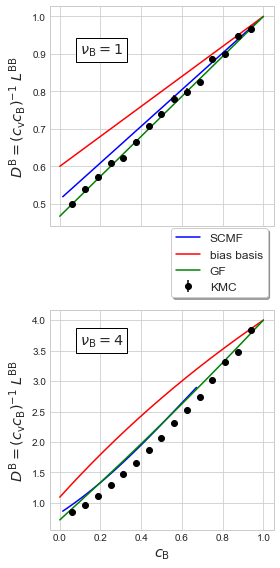

In [43]:
# 1: KMC, 2: GF, 3: bias basis, 4: SCMF
component, ylabel = (1,1), "$D^{\\rm B}=(c_{\\rm v}c_{\\rm B})^{-1}\ L^{\\rm{BB}}$"
plt.rcParams['figure.figsize'] = (4,8)

fig, ax1 = plt.subplots(nrows=2, ncols=1, sharex=True)
for ncase, ax in zip((1, 4), ax1):

    cL1 = np.array([[c, Lab[component]/c, dLab[component]/c] for c, Lab, dLab in 
                    zip(conc_KMC, Diff_results[ncase]['L_KMC'], Diff_results[ncase]['dL_KMC'])])
    cL2 = np.array([[c, Lab[component]/c] for c, Lab in zip(conc_GF, Diff_results[ncase]['L_GF']) if c!=0])
    cL3 = np.array([[c, Lab[component]/c] for c, Lab in zip(conc_GF, Diff_results[ncase]['L_bb']) if c!=0])
    cL4 = np.array([[c, Lab[component]/c] for c, Lab in zip(conc_SCMF, Diff_results[ncase]['L_SCMF'][3]) 
                    if np.abs(Lab[component])<2])
    ax.plot(cL4[:,0], cL4[:,1], 'b', label='SCMF')
    ax.plot(cL3[:,0], cL3[:,1], 'r', label='bias basis')
    ax.plot(cL2[:,0], cL2[:,1], 'g', label='GF')
    ax.errorbar(cL1[:,0], cL1[:,1], yerr=cL1[:,2], fmt='ko', label='KMC')
    ax.set_ylabel(ylabel, fontsize='x-large')
    ax.text(0.1, 0.9*ncase, "$\\nu_{\\rm B}=" + "{}$".format(ncase), 
            fontsize='x-large', bbox={'facecolor': 'white'})
ax.legend(bbox_to_anchor=(0.5,1.1,0.5,0.3), ncol=1, shadow=True, 
          frameon=True, fontsize='large', framealpha=1.)
ax.set_xlabel('$c_{\\rm{B}}$', fontsize='x-large')
plt.tight_layout()
plt.show()
# plt.savefig('solute-diffusivity.pdf', transparent=True, format='pdf')

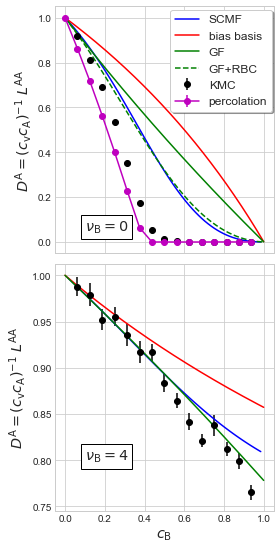

In [48]:
# 1: KMC, 2: GF, 3: bias basis, 4: SCMF
component, ylabel = (0,0), "$D^{\\rm A}=(c_{\\rm v}c_{\\rm A})^{-1}\ L^{\\rm{AA}}$"
plt.rcParams['figure.figsize'] = (4,8)

fig, ax1 = plt.subplots(nrows=2, ncols=1, sharex=True)
for ncase, ax in zip((0, 4), ax1):

    cL1 = np.array([[c, Lab[component]/(1-c), dLab[component]/(1-c)] for c, Lab, dLab in 
                    zip(conc_KMC, Diff_results[ncase]['L_KMC'], Diff_results[ncase]['dL_KMC'])])
    if ncase==0:
        cL1p = np.array([[0,1,0]] + [[c, Lab/(1-c), dLab/(1-c)] for c, Lab, dLab in 
                         zip(conc_KMC, Diff_results[ncase]['L_perc'], Diff_results[ncase]['dL_perc'])])
        cL2p = np.array([[c, Lab] for c, Lab in zip(conc_GF, Diff_results[ncase]['L_GFrbc']) if c!=1])
    cL2 = np.array([[c, Lab[component]/(1-c)] for c, Lab in zip(conc_GF, Diff_results[ncase]['L_GF']) if c!=1])
    cL3 = np.array([[c, Lab[component]/(1-c)] for c, Lab in zip(conc_GF, Diff_results[ncase]['L_bb']) if c!=1])
    cL4 = np.array([[c, Lab[component]/(1-c)] for c, Lab in zip(conc_SCMF, Diff_results[ncase]['L_SCMF'][3]) 
                    if np.abs(Lab[component])<2])
    ax.plot(cL4[:,0], cL4[:,1], 'b', label='SCMF')
    ax.plot(cL3[:,0], cL3[:,1], 'r', label='bias basis')
    ax.plot(cL2[:,0], cL2[:,1], 'g', label='GF')
    if ncase==0: ax.plot(cL2p[:,0], cL2p[:,1], 'g--', label='GF+RBC')
    ax.errorbar(cL1[:,0], cL1[:,1], yerr=cL1[:,2], fmt='ko', label='KMC')
    if ncase==0: ax.errorbar(cL1p[:,0], cL1p[:,1], yerr=cL1p[:,2], 
                             fmt='mo-', label='percolation')
    ax.set_ylabel(ylabel, fontsize='x-large')
    ax.text(0.1, 0.05 if ncase==0 else 0.8, "$\\nu_{\\rm B}=" + "{}$".format(ncase), fontsize='x-large', bbox={'facecolor': 'white'})
ax1[0].legend(bbox_to_anchor=(0.5,0.55,0.5,0.3), ncol=1, shadow=True, 
          frameon=True, fontsize='large', framealpha=1.)
ax.set_xlabel('$c_{\\rm{B}}$', fontsize='x-large')
plt.tight_layout()
plt.show()
# plt.savefig('solvent-diffusivity.pdf', transparent=True, format='pdf')